In [2]:
from face_detector_image_generator import face_detection_and_capture
from nan_finder import find_nan_columns
from keypoints_display_df import show_multiple_images_with_keypoints_in_dataframe
from keypoints_display_tf import show_multiple_images_with_keypoints_in_tf_datasets
from keypoints_flip_tf import flip_coordinate_and_image_horizontal_in_tf_dataset, flip_coordinate_and_image_vertical_in_tf_dataset
from keypoints_flip_df import flip_coordinate_and_image_horizontal_in_df, flip_coordinate_and_image_vertical_in_df
from tf_data_split import split_and_prepare_datasets
from Canny import Canny

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
facial_keypoints_train_dataset_loaded = tf.data.Dataset.load("./Assets/datasets/facial_keypoints_train_dataset.tfrecord", compression="GZIP")
facial_keypoints_test_dataset_loaded = tf.data.Dataset.load("./Assets/datasets/facial_keypoints_test_dataset.tfrecord", compression="GZIP")

In [4]:
print(f'info train data: {facial_keypoints_train_dataset_loaded}')
print(f'number of train data: {len(facial_keypoints_train_dataset_loaded)}')
print()
print(f'info test data: {facial_keypoints_test_dataset_loaded}')
print(f'number of test data: {len(facial_keypoints_test_dataset_loaded)}')

info train data: <_LoadDataset element_spec=(TensorSpec(shape=(96, 96, 1), dtype=tf.float32, name=None), TensorSpec(shape=(30,), dtype=tf.float64, name=None))>
number of train data: 14098

info test data: <_LoadDataset element_spec=TensorSpec(shape=(96, 96, 1), dtype=tf.float32, name=None)>
number of test data: 1783


=======================Check Train Data======================
    shape img: (96, 96, 1)
    dtype img: float32
    max intensity: 1.0
    min intensity: 0.0

    keypoint: [64.33293617 34.9700766  29.9492766  33.44871489 58.85617021 35.27434894
 70.7227234  36.18716596 36.0347234  34.36153191 24.47251064 33.14444255
 53.98740426 28.27594894 78.63421277 30.4059234  42.72885106 26.14604255
 16.8653617  27.05885957 48.20629787 55.66093617 56.42144681 76.352
 35.12238298 76.04765957 46.68459574 70.26655319 45.46791489 85.48017021]
    keypoint-shape: (30,)
    image-type: float64
    max-value: 85.4801702128
    min-value: 16.8653617021


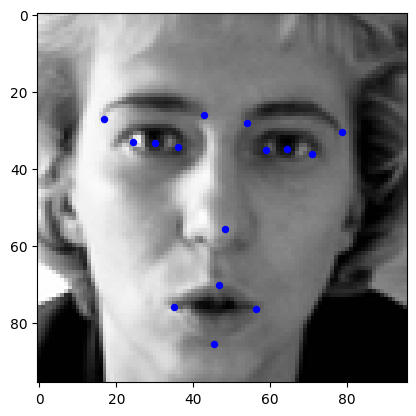

In [5]:
for img, keypoint in facial_keypoints_train_dataset_loaded.skip(1).take(1).as_numpy_iterator():
    print(f"{'Check Train Data'.center(61, '=')}")
    print(f'''    shape img: {img.shape}
    dtype img: {img.dtype}
    max intensity: {tf.reduce_max(img)}
    min intensity: {tf.reduce_min(img)}

    keypoint: {keypoint}
    keypoint-shape: {keypoint.shape}
    image-type: {keypoint.dtype}
    max-value: {tf.reduce_max(keypoint)}
    min-value: {tf.reduce_min(keypoint)}'''
    )

    for i in range(0, len(keypoint), 2):
        x = keypoint[i]
        y = keypoint[i+1]
        plt.scatter(x, y, s=75, marker='.', c='blue')
    plt.imshow(img, cmap='gray')
plt.show()

=======================Check Test Data=======================
    shape img: (96, 96, 1)
    dtype img: float32
    max intensity: 0.9686274528503418
    min intensity: 0.007843137718737125
    keypoint value: [64.33293617 34.9700766  29.9492766  33.44871489 58.85617021 35.27434894
 70.7227234  36.18716596 36.0347234  34.36153191 24.47251064 33.14444255
 53.98740426 28.27594894 78.63421277 30.4059234  42.72885106 26.14604255
 16.8653617  27.05885957 48.20629787 55.66093617 56.42144681 76.352
 35.12238298 76.04765957 46.68459574 70.26655319 45.46791489 85.48017021]
    dtype keypoint: float64


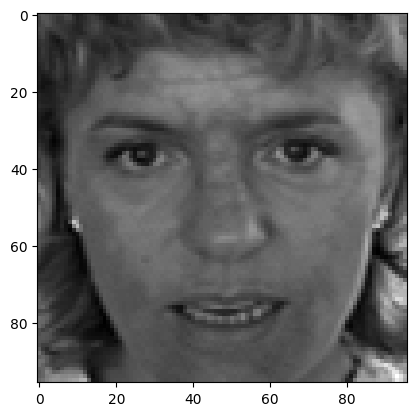

In [8]:
for img in facial_keypoints_test_dataset_loaded.skip(1).take(1).as_numpy_iterator():
    print(f"{'Check Test Data'.center(61, '=')}")
    print(f'''    shape img: {img.shape}
    dtype img: {img.dtype}
    max intensity: {tf.reduce_max(img)}
    min intensity: {tf.reduce_min(img)}
    keypoint value: {keypoint}
    dtype keypoint: {keypoint.dtype}'''
    )
    plt.imshow(img, cmap='gray')
plt.show()

In [6]:
def processed_image(image, keypoint):
    image = tf.cast(image, tf.float32)
    image = image / tf.reduce_max(image)
    return image, keypoint

facial_keypoints_datasets_processed = facial_keypoints_train_dataset_loaded.map(processed_image, num_parallel_calls=tf.data.AUTOTUNE)
facial_keypoints_datasets_cached = facial_keypoints_datasets_processed.cache()

==========================Check data=========================
    shape img: (96, 96, 1)
    dtype img: float32
    max intensity: 1.0
    min intensity: 0.14173229038715363

    keypoint: [65.23018868 34.34264151 28.80271698 33.93781132 58.75381132 35.55713208
 70.08633962 35.55713208 34.46943396 35.15230189 24.35049057 35.55713208
 53.89675472 28.27109434 76.15788679 28.27109434 38.51683019 26.24784906
 16.6605283  27.86716981 47.42128302 51.74671698 57.13449057 71.57977358
 34.06460377 70.77011321 46.46943396 65.26007547 46.20679245 81.69781132]
    keypoint-shape: (30,)
    image-type: float64
    max-value: 81.6978113208
    min-value: 16.6605283019


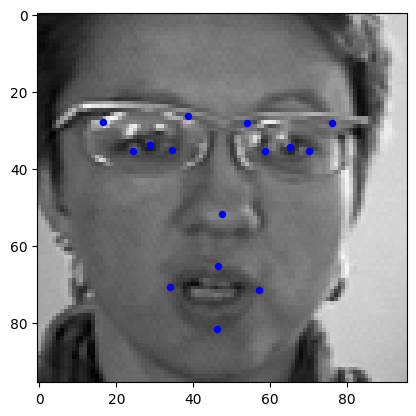

In [7]:
for img, keypoint in facial_keypoints_datasets_cached.skip(10).take(1).as_numpy_iterator():
    print(f"{'Check data'.center(61, '=')}")
    print(f'''    shape img: {img.shape}
    dtype img: {img.dtype}
    max intensity: {tf.reduce_max(img)}
    min intensity: {tf.reduce_min(img)}

    keypoint: {keypoint}
    keypoint-shape: {keypoint.shape}
    image-type: {keypoint.dtype}
    max-value: {tf.reduce_max(keypoint)}
    min-value: {tf.reduce_min(keypoint)}'''
    )

    for i in range(0, len(keypoint), 2):
        x = keypoint[i]
        y = keypoint[i+1]
        plt.scatter(x, y, s=75, marker='.', c='blue')
    plt.imshow(img, cmap='gray')
plt.show()

In [8]:
train_dataset_batched, valid_dataset_batched = split_and_prepare_datasets(facial_keypoints_datasets_cached, batch_size=64, train_split=0.9, shuffle_buffer_size=None)

=================================== Training Dataset ===================================
Info data: <_TakeDataset element_spec=(TensorSpec(shape=(96, 96, 1), dtype=tf.float32, name=None), TensorSpec(shape=(30,), dtype=tf.float64, name=None))>
Training Split: 0.9
Number of data: 12688
AFTER BATCH: 64
Number of data: 199
=================================== Validation Dataset ===================================
Info data: <_SkipDataset element_spec=(TensorSpec(shape=(96, 96, 1), dtype=tf.float32, name=None), TensorSpec(shape=(30,), dtype=tf.float64, name=None))>
Validation Split: 0.1
Number of data: 1410
AFTER BATCH: 64
Number of data: 23


In [11]:
facial_keypoints_concatenated_test_dataset_batched = facial_keypoints_test_dataset_loaded.batch(64)
facial_keypoints_concatenated_test_dataset_prefetched = facial_keypoints_concatenated_test_dataset_batched.prefetch(tf.data.AUTOTUNE)

In [10]:
# Fungsi masked loss
def masked_mse_loss(y_true, y_pred):
    mask = tf.not_equal(y_true, 0)  # Masker untuk nilai yang tidak nol (keypoint yang tersedia)
    mask = tf.cast(mask, tf.float32)  # Konversi ke float
    loss = tf.square(y_true - y_pred) * mask  # Hitung MSE hanya pada keypoint yang tersedia
    loss = tf.reduce_sum(loss) / tf.reduce_sum(mask)  # Rata-rata loss berdasarkan jumlah keypoint yang tersedia
    return loss

# Fungsi untuk membuat blok residual dengan konvolusi strided
def residual_block(x, filters):
    residual = x
    x = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', padding='same', strides=2)(x)
    residual = tf.keras.layers.Conv2D(filters, (1, 1), padding='same', strides=2)(residual)
    x = tf.keras.layers.add([x, residual])
    return x

# Arsitektur ML-ResNet
def create_ml_resnet(input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Lapisan pertama
    x = tf.keras.layers.Conv2D(32, (11, 11), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    # Blok residual pertama
    x = residual_block(x, 64)

    # Blok residual kedua
    x = residual_block(x, 128)

    # Lapisan akhir
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1000, activation='relu')(x)
    x = tf.keras.layers.Dense(30)(x)  # 15 keypoints dengan masing-masing x dan y koordinat

    model = tf.keras.models.Model(inputs, x)
    return model

learning_rate_adam = tf.keras.optimizers.Adam(
  learning_rate=0.001,
  beta_1=0.9,
  beta_2=0.999,
)

# Membuat dan mengkompilasi model
input_shape = (96, 96, 1)
model = create_ml_resnet(input_shape)
model.compile(optimizer=learning_rate_adam, loss=masked_mse_loss)
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 96, 96, 1)]          0         []                            
                                                                                                  
 conv2d_7 (Conv2D)           (None, 96, 96, 32)           3904      ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_1 (MaxPoolin  (None, 48, 48, 32)           0         ['conv2d_7[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_8 (Conv2D)           (None, 48, 48, 64)           18496     ['max_pooling2d_1[0][0]'

In [ ]:
target_path_keras_model = '/content/drive/MyDrive/Colab Notebooks/model/facial keypoints detection model/facial_keypoints_detection_model.keras'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=target_path_keras_model,  # Path untuk menyimpan model
    monitor='val_loss',  # Metrik yang dipantau
    save_best_only=True,  # Hanya menyimpan model terbaik
    save_weights_only=False,  # Menyimpan seluruh model (bukan hanya bobotnya)
    mode='min',  # Mode untuk memantau metrik (min untuk loss)
    verbose=1,
)

plateau_callback = tf.keras.callbacks.ReduceLROnPlateau(
  monitor='val_loss',  # Metrik yang akan dipantau
  factor=0.5,  # Faktor pengurangan learning rate. new_lr = lr * factor
  patience=20,  # Jumlah epoch tanpa perbaikan setelah learning rate akan dikurangi
  verbose=1,  # Output
  mode='auto',  # Mode otomatis menurunkan learning rate baik ketika metrik berhenti meningkat atau menurun
  min_delta=0.001,  # Perubahan minimum dalam metrik yang dianggap sebagai peningkatan
  cooldown=0,  # Jumlah epoch untuk menunggu sebelum melanjutkan operasi normsal setelah learning rate dikurangi.
  min_lr=0  # Batas bawah learning rate
)

early_stopping = tf.keras.callbacks.EarlyStopping(
  monitor='val_loss',
  patience=50,
  restore_best_weights=True,
  verbose=1
)

history = model.fit(
    train_dataset_batched,
    validation_data=valid_dataset_batched,
    epochs=250,
    callbacks=[
    plateau_callback,
    early_stopping,
    checkpoint_callback
  ]
)

In [ ]:
# Evaluasi model yang dimuat
loaded_evaluation = model.evaluate(valid_dataset_batched)
print(f'Evaluation on validation data (loaded model): {loaded_evaluation}')

In [ ]:
idx = np.random.randint(0, len(valid_dataset_batched))

plt.figure(figsize=(10,5))
for image, keypoint in valid_dataset_batched.skip(idx).take(1):
  image = image = tf.expand_dims(image[0], axis=0)
  keypoint = keypoint[0]

  pred_keypoints = model.predict(image)
  pred_keypoints = tf.squeeze(pred_keypoints)

  plt.subplot(1, 2, 1)
  plt.imshow(image[0], cmap='gray')
  plt.title('original')
  # Loop through pairs of labels (x, y)
  for i in range(0, len(keypoint), 2):
    x = keypoint[i].numpy()
    y = keypoint[i+1].numpy()
    plt.scatter(x, y, s=200, marker='.', c='blue')

  plt.subplot(1, 2, 2)
  plt.imshow(image[0], cmap='gray')
  plt.title('prediction')
  # Loop through pairs of labels (x, y)
  for i in range(0, len(pred_keypoints), 2):
    x = pred_keypoints[i].numpy()
    y = pred_keypoints[i+1].numpy()
    plt.scatter(x, y, s=200, marker='.', c='blue')

plt.show()